<a href="https://colab.research.google.com/github/ShadmanRohan/Bengali-Sarcasm-Detection/blob/main/WeightedLoss_wTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload the training data first after Colab is initiated
%%capture
!pip install datasets
!pip install transformers
!pip install git+https://github.com/csebuetnlp/normalizer

In [ ]:
!nvidia-smi

Mon Oct 24 10:52:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Data Preparation**

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from normalizer import normalize
from transformers.modeling_outputs import TokenClassifierOutput, SequenceClassifierOutput
from transformers import AutoModelForSequenceClassification, AutoModel, AutoConfig

# Load Data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train = train.rename(columns={"headlines": "text", "category": "labels"}) # change headings
test = test.rename(columns={"headlines": "text", "category": "labels"}) # change headings

train = train.dropna()
#train = train.astype({'label':float})
#train = train.drop(['Id'], axis=1)
train['text'] = pd.DataFrame(train['text'].map(lambda x: normalize(x)))
test['text'] = pd.DataFrame(test['text'].map(lambda x: normalize(x)))


In [ ]:
from datasets import load_dataset

# Split Data
random_seed = 42
train_df = train.sample(frac=0.90, random_state=random_seed)
valid_df = train.drop(train_df.index)
assert len(train) == len(train_df) + len(valid_df), "Dataset sizes don't add up" # check for proper split

# Create New Data Files
valid_df.to_csv('validation_data.csv', index=False)
train_df.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

# Load Data (train + val)
training_data = load_dataset("csv", data_files={'train': ['/content/train_data.csv'],'validation': ['/content/validation_data.csv']})

#training_data

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f997b5aa54bc9bfc/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score 

# Helper Functions
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_weighted = f1_score(labels, preds, average="weighted")
    f1_macro = f1_score(labels, preds, average="macro") 
    f1_micro = f1_score(labels, preds, average="micro") 
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1_weighted": f1_weighted, "f1_macro": f1_macro, "f1_micro": f1_micro}

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch

num_labels = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ckpt = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=256)

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))
training_data_encoded = training_data.map(tokenize, batched=True, batch_size=64)

  0%|          | 0/683 [00:00<?, ?ba/s]

  0%|          | 0/76 [00:00<?, ?ba/s]

**Weighted Loss (Ignore... Didn't Work Well)**

In [ ]:
# import torch.nn.functional as Fun

# # Trainer with Weighted Loss
# from transformers import Trainer, TrainingArguments
# class WeightedTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits
#         labels = Fun.one_hot(labels, num_classes = 2).to(device)

#         #print(logits)
#         #print(labels)
#         class_weight = torch.FloatTensor([1, 1.25]).to(device)
#         loss_fct = torch.nn.CrossEntropyLoss(weight=class_weight, reduction='mean')

#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), 
#                         labels.float().view(-1, self.model.config.num_labels)).sum()
#         #print(loss)
#         return (loss, outputs) if return_outputs else loss

In [ ]:
# # Custom Model

# num_labels = 2
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class CustomBERTModel(nn.Module):
#   def __init__(self, checkpoint, num_labels): 
#     super(CustomBERTModel, self).__init__()
#     self.num_labels = num_labels
#     self.bert = AutoModel.from_pretrained(checkpoint, config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
#     ### New layers:
#     self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
#     self.linear = nn.Linear(256*2, num_labels)
          

#   def forward(self, input_ids=None, attention_mask=None,labels=None):
#     sequence_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

#     # sequence_output has the following shape: (batch_size, sequence_length, 768)
#     lstm_output, (h,c) = self.lstm(sequence_output[0]) ## extract the 1st token's embeddings
#     hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
#     logits = self.linear(hidden.view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

#     loss = None
#     if labels is not None:
#       loss_fct = nn.CrossEntropyLoss()
#       loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
#     print(loss)
#     return SequenceClassifierOutput(loss = loss, logits=logits, hidden_states=sequence_output.hidden_states, attentions=sequence_output.attentions)

# #model = CustomBERTModel(model_ckpt, num_labels).to(device)

In [ ]:
from huggingface_hub import notebook_login 
notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments 
batch_size = 64
logging_steps = len(training_data_encoded["train"]) // batch_size 
model_name = f"{model_ckpt}-sarcasm-detection"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3, 
                                  #num_training_steps=100, 
                                  learning_rate=2e-5,
                                  #warmup_steps=10000,
                                  per_device_train_batch_size=batch_size, 
                                  per_device_eval_batch_size=batch_size, 
                                  eval_steps=100,
                                  logging_steps = 100,
                                  weight_decay=0.01,
                                  evaluation_strategy="steps", 
                                  save_strategy="steps",
                                  disable_tqdm=False,
                                  #logging_steps=logging_steps,
                                  save_steps = 100, 
                                  save_total_limit = 2,
                                  load_best_model_at_end=True,
                                  push_to_hub=True,
                                  log_level="error")

In [ ]:
%%capture
#!sudo apt-get install git-lfs
from transformers import Trainer
# select Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=training_data_encoded["train"], 
                  eval_dataset=training_data_encoded["validation"],
                  tokenizer=tokenizer)

/content/csebuetnlp/banglabert-sarcasm-detection is already a clone of https://huggingface.co/Shadman-Rohan/banglabert-sarcasm-detection. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
#import pdb
#pdb.set_trace()

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,F1 Micro
100,0.293500,0.181934,0.938776,0.935423,0.837728,0.938776
200,0.181200,0.180993,0.939600,0.932879,0.824250,0.939600
300,0.161100,0.178050,0.942486,0.935352,0.829322,0.942486
400,0.147000,0.138242,0.954855,0.952603,0.881367,0.954855
500,0.136500,0.161889,0.948877,0.943346,0.851961,0.948877
600,0.130300,0.134180,0.957535,0.954583,0.884550,0.957535
700,0.121100,0.151443,0.955267,0.951944,0.877401,0.955267
800,0.094300,0.157802,0.960214,0.957386,0.891546,0.960214
900,0.090500,0.143012,0.959802,0.957680,0.893824,0.959802
1000,0.089900,0.160019,0.954236,0.949835,0.869987,0.954236


Several commits (5) will be pushed upstream.


TrainOutput(global_step=2049, training_loss=0.10358629440784221, metrics={'train_runtime': 1379.5369, 'train_samples_per_second': 94.932, 'train_steps_per_second': 1.485, 'total_flos': 1902544735755000.0, 'train_loss': 0.10358629440784221, 'epoch': 3.0})

**Evaluate Model**

In [ ]:
# check if trainer using the best validation model
preds_output = trainer.predict(training_data_encoded["validation"])
preds_output.metrics

{'test_loss': 0.12869291007518768,
 'test_accuracy': 0.9651618223046794,
 'test_f1_weighted': 0.9637525729119033,
 'test_f1_macro': 0.9099831708225743,
 'test_f1_micro': 0.9651618223046794,
 'test_runtime': 10.7349,
 'test_samples_per_second': 451.892,
 'test_steps_per_second': 7.08}

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='pred') 
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Un-normalized confusion matrix")
  plt.show()

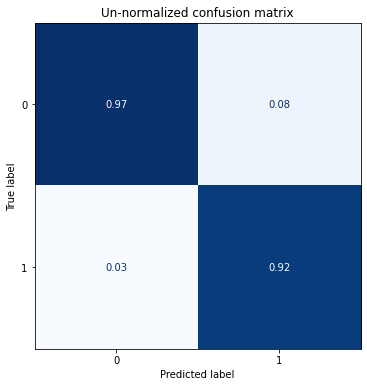

In [ ]:
# Confusion Matrix (Normalized)
import numpy as np
import matplotlib.pyplot as plt

y_preds = np.argmax(preds_output.predictions, axis=1)
#labels = training_data_encoded["train"].features["label"].names
labels = [0,1]
y_valid = training_data_encoded["validation"]["labels"]

plot_confusion_matrix(y_preds, y_valid, labels)

**Inspect Loss on Train/Validation Datapoints**

In [ ]:
from torch.nn.functional import cross_entropy 
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model 
    inputs = {k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names}

    with torch.no_grad(): 
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        #class_weight = torch.FloatTensor([1, 1.25]).to(device)

        loss = cross_entropy(output.logits, batch["labels"].to(device), reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns 
    return {"loss": loss.cpu().numpy(),
    "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
training_data_encoded.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
# Compute loss values
#test_data_encoded["test"] = test_data_encoded["test"].map(forward_pass_with_label, batched=True, batch_size=16)
training_data_encoded["train"] = training_data_encoded["train"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/3002 [00:00<?, ?ba/s]

In [ ]:
#def label_int2str(row):
#    return emotions["train"].features["label"].int2str(row)
training_data_encoded.set_format("pandas")
cols = ["text", "labels", "predicted_label", "loss", "Id"] 
df_train_loss = training_data_encoded["train"][:][cols]
#df_test["label"] = df_test["label"].apply(label_int2str) 
#df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))
df_train_loss.sort_values("loss", ascending=False).head(500)

,text,labels,predicted_label,loss,Id
42903,কাল সারাদেশে বিএনপির বিক্ষোভ সমাবেশ,1,0,5.482750,18295
46116,টেনিসে জাতীয় চ্যাম্পিয়ন কিরণ বেদী,1,0,5.471768,25171
18755,ফ্রান্সে বোরকার ওপর নিষেধাজ্ঞা কার্যকর,1,0,5.465158,7859
18443,অস্ট্রেলিয়ার নাগরিকত্ব পেতে যাচ্ছেন শাবনূর,1,0,5.442190,29854
7523,জামায়াতের নতুন আমির ঘোষণার সম্ভাবনা,1,0,5.442174,44161
...,...,...,...,...,...
5551,২০২০ সালের কাবার গিলাফ তৈরির কাজ শুরু হয়ে গেছ...,0,1,2.540622,37266
31381,ইসলাম গ্রহন করেছেন রাজবধু কেট,1,0,2.527251,20832
11598,"ফুরিয়ে যাচ্ছে জীবন, স্বপ্নের বিয়েটা পাঁচ বছর...",0,1,2.526224,12348
2448,পা দিয়ে বিমান চালিয়েই পাইলটের লাইসেন্স,1,0,2.522029,16866


**Infer on Test**

In [ ]:
#test_data
test_data = load_dataset("csv", data_files={'test': ['/content/test_data.csv']})
test_data_encoded = test_data.map(tokenize, batched=True, batch_size=64)
test_data_encoded

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-5b866a37e35b3fae/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?ba/s]

DatasetDict({
    test: Dataset({
        features: ['Id', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12127
    })
})

In [ ]:
from torch.nn.functional import cross_entropy 
def forward_pass_without_label(batch):
    # Place all input tensors on the same device as the model 
    inputs = {k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names}

    with torch.no_grad(): 
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)

        #loss = cross_entropy(output.logits, batch["label"].to(device), weight=class_weight, reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns 
    return {"logits": output.logits,
    "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
test_data_encoded.set_format("torch", columns=["input_ids", "attention_mask"])
# Compute loss values
test_data_encoded["test"] = test_data_encoded["test"].map(forward_pass_without_label, batched=True, batch_size=16)

  0%|          | 0/758 [00:00<?, ?ba/s]

In [ ]:
test_data_encoded.set_format("pandas")
cols = ["Id", "text", "predicted_label", "logits"] 
#cols =  ["Id", "text", "predicted_label"]

df_test = test_data_encoded["test"][:][cols]
#df_test["label"] = df_test["label"].apply(label_int2str) 
#df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

df_test.head(500) # check outputs on test

,Id,text,predicted_label,logits
0,0,"মেসি-রোনাল্ডোর দিন শেষ, ব্যালন ডিঅর পাচ্ছেন মড...",0,"[3.0073128, -2.78832]"
1,1,রানি মুখার্জির ফেরা নিশ্চিত হল,0,"[3.3838468, -3.1465037]"
2,2,মোদি মিথ্যাবাদী : গগৈ,0,"[3.1495554, -2.963415]"
3,3,"সন্ত্রাস, দুর্নীতিতে জড়িত কাউকে ছাড় দেয়া হব...",0,"[3.2835371, -2.9935427]"
4,4,আবারো শেষের নায়ক রামোস,0,"[3.2992747, -3.0825925]"
...,...,...,...,...
495,495,উ. কোরিয়ামুখী লাউড স্পিকার বন্ধ করল দ. কোরিয়া,0,"[3.1306176, -2.9036472]"
496,496,আগামীকাল মাঠে গড়াচ্ছে পাইওনিয়র ফুটবল,0,"[3.2449825, -2.9921038]"
497,497,নবির ব্যাটে আফগানিস্তানের লড়াকু সংগ্রহ,0,"[3.4269457, -3.185881]"
498,498,চ্যাম্পিয়ন ফেনী,0,"[3.2804384, -3.138201]"


**Prepare Submission File**

In [ ]:
df_test = df_test.rename(columns={"predicted_label": "category"})
df_test = df_test.drop(['text', 'logits'], axis=1)
# create file
df_test.to_csv("buet_bert_90_10_normalized_submission.csv", index=False)
t = pd.read_csv('buet_bert_90_10_normalized_submission.csv') # sanity check
t

,Id,category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
12122,12122,0
12123,12123,0
12124,12124,1
12125,12125,0


In [ ]:
%%capture
trainer.push_to_hub(commit_message="Training completed!")

Several commits (6) will be pushed upstream.
The progress bars may be unreliable.
remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Shadman-Rohan/banglabert-sarcasm-detection
   758ecc7..96c4981  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Shadman-Rohan/banglabert-sarcasm-detection
   758ecc7..96c4981  main -> main

To https://huggingface.co/Shadman-Rohan/banglabert-sarcasm-detection
   96c4981..6aaaad9  main -> main

   96c4981..6aaaad9  main -> main



**Inference**

In [ ]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "Shadman-Rohan/banglabert-sarcasm-detection"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/845 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
headline = "৪০ বছর পূর্তিতে কানাডায় মাইলসের সিরিজ কনসার্ট" 
preds = classifier(headline, return_all_scores=True)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:92: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  UserWarning,


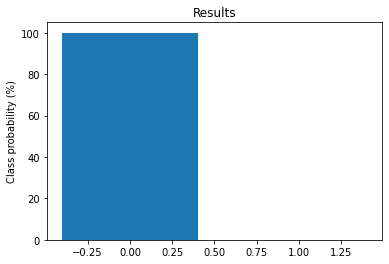

In [ ]:
import pandas as pd

preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title("Results")
plt.ylabel("Class probability (%)")
plt.show()